Task - 2

Question
Implement a circuit that returns  |01⟩  and  |10⟩  with equal probability.

Requirements :

-The circuit should consist only of CNOTs, RXs and RYs.

-Start from all parameters in parametric gates being equal to 0 or randomly chosen.

-You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like).

-Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise.

Compare the results for different numbers of measurements: 1, 10, 100, 1000.


Solution

Pennylane is used for solving the above problem. To compare noisy models and noise-less simulations, pennylane-qiskit plugin is used.

In [1]:
#Importing required libraries
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#Importing noisy model
from qiskit import IBMQ
IBMQ.save_account('0466d93ef3100928b0083abd9f9a3385d0bced5af5d5729748d43795ad7b963767a30c15da92ad836c18ecbb179ab4a0093b64b1f957f98b5c48240898d3d70d')
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


The solution can be achieved by using H, X and CNOT gate. But we are asked to use only RX, RY and CNOT gates. So the below circuit

In [3]:
def circuit(theta):
    qml.RY(theta[0], wires=0)
    
    qml.RY(theta[1], wires=1)
    
    qml.CNOT(wires=[0, 1])

Initializing the circuit with noisy model

In [4]:
num_qubits = 2

dev = qml.device("qiskit.aer", wires=num_qubits, shots=1000, noise_model = noise_model, analytic=False)

@qml.qnode(dev)
def state(theta):
    
    circuit(theta)
    
    return qml.probs(wires=[0,1])

Initializing the circuit with noiseless simulation

In [7]:
num_qubits = 2

dev_noiseless = qml.device("qiskit.aer", wires=num_qubits, shots=1000, analytic=False)

@qml.qnode(dev_noiseless)
def state_noiseless(theta):
    
    circuit(theta)
    
    return qml.probs(wires=[0,1])

qml.probs() will return a flat array or tensor containing the (marginal) probabilities of each quantum state in the lexigrophic ordering.

We need the probability of |01> and |10> to be 0.5 and all other state probabilities should be 0.

So the cost function is defined as below.

In [8]:
def cost(theta):           #cost function for noisy simulation
    p_00, p_01, p_10, p_11 = state(theta)
    return ((p_00-0)**2 + (p_01-0.5)**2 + (p_10-0.5)**2 + (p_11-0)**2)

In [9]:
def cost_noiseless(theta):          #cost function for noiseless simulation
    p_00, p_01, p_10, p_11 = state_noiseless(theta)
    return ((p_00-0)**2 + (p_01-0.5)**2 + (p_10-0.5)**2 + (p_11-0)**2)

Gradient Desent Optimizer library from Pennylane is used to find out the optimum parameters. Step size is 0.6

In [10]:
prob = []
all_costs = []

for num_shots in [1, 10, 100, 1000]:
    dev.shots = num_shots
    initial_parameters = np.random.randn(2) #starting with random parameters
    
    steps = 40 # Number of steps of optimization
    
    parameters = initial_parameters.copy()
    
    optimizer = qml.GradientDescentOptimizer(stepsize=0.6) #The Gradient Descent Optimizer
    
    costs = []
    
    print('--------------------------------\n')
    print('For {0} shots\n'.format(num_shots))
    for i in range(steps):
        costs.append(cost(parameters))
        parameters = optimizer.step(cost, parameters)
        
        if (i%10 == 0):
            print('The cost for {0} measurement sampling is {1}\n'.format(num_shots, cost(parameters)))
            print('The parameters are {0}\n'.format(parameters))
    all_costs.append(costs)

    p = [0, 0, 0, 0]
    p[0], p[1], p[2], p[3] = state(parameters)
    print('Final probability of states is as follows: \n')
    print('\n Probality of 00 is: {0} \n Probality of 01 is: {1} \n Probality of 10 is: {2} \n Probality of 11 is: {3}'.format(p[0], p[1], p[2], p[3]))
    prob.append(p)

--------------------------------

For 1 shots

The cost for 1 measurement sampling is 1.5

The parameters are [ 2.78082809 -0.60420726]

The cost for 1 measurement sampling is 0.5

The parameters are [ 1.88082809 -2.40420726]

The cost for 1 measurement sampling is 0.5

The parameters are [ 2.78082809 -3.00420726]

The cost for 1 measurement sampling is 0.5

The parameters are [ 1.58082809 -3.30420726]

Final probability of states is as follows: 


 Probality of 00 is: 1.0 
 Probality of 01 is: 0.0 
 Probality of 10 is: 0.0 
 Probality of 11 is: 0.0
--------------------------------

For 10 shots

The cost for 10 measurement sampling is 1.08

The parameters are [-1.26250999  0.17508919]

The cost for 10 measurement sampling is 0.30000000000000004

The parameters are [-1.85050999 -1.90091081]

The cost for 10 measurement sampling is 0.01999999999999999

The parameters are [-1.44850999 -2.56691081]

The cost for 10 measurement sampling is 0.019999999999999997

The parameters are [-1.52050

In [11]:
print('The final parameters are {0} for with noisy simulations.'.format(parameters))

The final parameters are [1.57123089 2.93360862] for with noisy simulations.


Visualization

<BarContainer object of 4 artists>

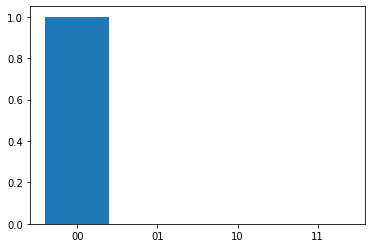

In [12]:
plt.bar(['00','01','10', '11'], prob[0]) #Probability Distribution for shots 1

<BarContainer object of 4 artists>

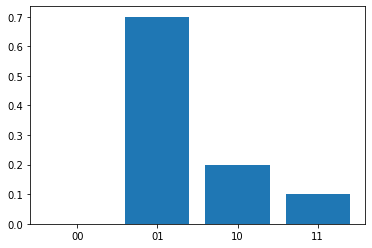

In [13]:
plt.bar(['00','01','10', '11'], prob[1]) #Probability Distribution for shots 1

<BarContainer object of 4 artists>

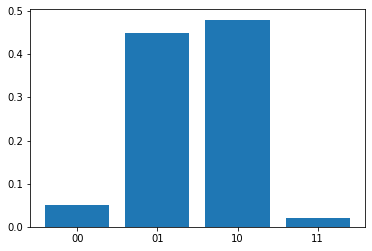

In [14]:
plt.bar(['00','01','10', '11'], prob[2]) #Probability Distribution for shots 1

<BarContainer object of 4 artists>

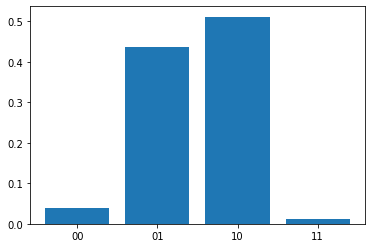

In [15]:
plt.bar(['00','01','10', '11'], prob[3]) #Probability Distribution for shots 1

As we can see from above graphs, the error reduces as we increase the number of shots. For 100 and 1000 shots, we almost got desired probabilities in noisy model.

Cost Evaluation

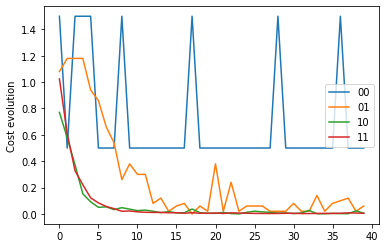

In [16]:
plt.plot(all_costs[0], label ="00")
plt.plot(all_costs[1], label ="01")
plt.plot(all_costs[2], label ="10")
plt.plot(all_costs[3], label ="11")
plt.ylabel('Cost evolution')
plt.legend()
plt.show()

Optimization using noise-less simulation. Same parameters are used as in the case of noisy simulations.

In [20]:
prob = []
all_costs = []

for num_shots in [1000, 100, 10, 1]:
    dev_noiseless.shots = num_shots
    initial_parameters = np.random.randn(2) #starting with random parameters
    
    steps = 40 # Number of steps of optimization
    
    parameters = initial_parameters.copy()
    
    optimizer = qml.GradientDescentOptimizer(stepsize=0.6) #The Gradient Descent Optimizer
    
    costs = []
    
    print('--------------------------------\n')
    print('For {0} shots\n'.format(num_shots))
    for i in range(steps):
        costs.append(cost_noiseless(parameters))
        parameters = optimizer.step(cost_noiseless, parameters)
        
        if (i%10 == 0):
            print('The cost for {0} measurement sampling is {1}\n'.format(num_shots, cost(parameters)))
            print('The parameters are {0}\n'.format(parameters))
    all_costs.append(costs)

    p = [0, 0, 0, 0]
    p[0], p[1], p[2], p[3] = state_noiseless(parameters)
    print('Final probability of states is as follows: \n')
    print('\n Probality of 00 is: {0} \n Probality of 01 is: {1} \n Probality of 10 is: {2} \n Probality of 11 is: {3}'.format(p[0], p[1], p[2], p[3]))
    prob.append(p)

--------------------------------

For 1000 shots

The cost for 1000 measurement sampling is 0.607574

The parameters are [ 1.69000041 -0.87372749]

The cost for 1000 measurement sampling is 0.011785999999999998

The parameters are [ 1.59942321 -2.54600609]

The cost for 1000 measurement sampling is 0.005332

The parameters are [ 1.56228441 -2.73033629]

The cost for 1000 measurement sampling is 0.004113999999999998

The parameters are [ 1.52711181 -2.80828529]

Final probability of states is as follows: 


 Probality of 00 is: 0.008 
 Probality of 01 is: 0.507 
 Probality of 10 is: 0.476 
 Probality of 11 is: 0.009
--------------------------------

For 100 shots

The cost for 100 measurement sampling is 0.744408

The parameters are [ 1.71298452 -0.65020348]

The cost for 100 measurement sampling is 0.024026000000000006

The parameters are [ 1.67998452 -2.48380348]

The cost for 100 measurement sampling is 0.007309999999999997

The parameters are [ 1.54558452 -2.70334348]

The cost for 

In [19]:
print('The final parameters as {0} for with simulations.'.format(parameters))

The final parameters as [-1.57508434  2.8123664 ] for with simulations.


Visualization

<BarContainer object of 4 artists>

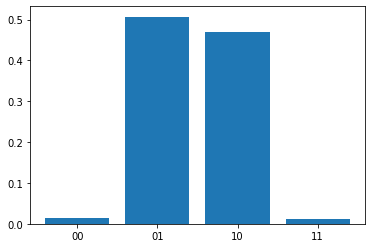

In [18]:
plt.bar(['00','01','10', '11'], prob[0])   #Probability Distribution for shots 1000

<BarContainer object of 4 artists>

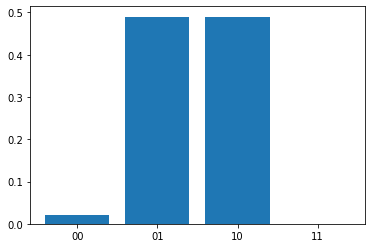

In [21]:
plt.bar(['00','01','10', '11'], prob[1])   #Probability Distribution for shots 100

<BarContainer object of 4 artists>

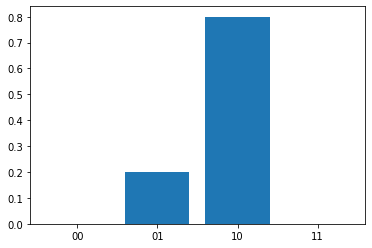

In [22]:
plt.bar(['00','01','10', '11'], prob[2])   #Probability Distribution for shots 10

<BarContainer object of 4 artists>

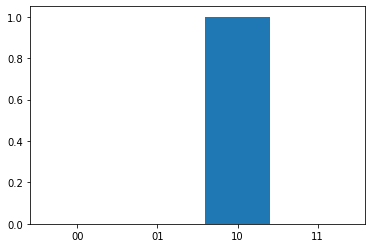

In [23]:
plt.bar(['00','01','10', '11'], prob[3])   #Probability Distribution for shots 1

The same trend can be seen in this case too, as the number of shots increasing, accuracy is also increasing.